In [13]:
from transformers import pipeline

# Load the zero-shot classification pipeline
pipe = pipeline(
    "zero-shot-classification",
    model="MoritzLaurer/deberta-v3-base-zeroshot-v2.0"
)


Device set to use mps:0


In [29]:
# your text
text = "System.OutOfMemoryException: Exception of type 'System.OutOfMemoryException' was thrown. correlation_id=c94ee0ca-c95d-4d3b-b7e1-c9026f2c8eb5"

# candidate labels
labels = ["anomaly", "normal"]

# classify
result = pipe(text, candidate_labels=labels)

print(result)

{'sequence': "System.OutOfMemoryException: Exception of type 'System.OutOfMemoryException' was thrown. correlation_id=c94ee0ca-c95d-4d3b-b7e1-c9026f2c8eb5", 'labels': ['anomaly', 'normal'], 'scores': [0.976557731628418, 0.023442290723323822]}


In [15]:
import pandas as pd

df = pd.read_excel("/Users/ahmedgamal/Downloads/hugging_face/LOG_dataset.xlsx")

In [16]:
df.head()

,backend,environment,host,source_ip,log_level,event_code,message,label
0,Apache,prod,ingress-1.prod.contoso.net,69.145.127.180,DEBUG,APC-200,"AH00128: Served /api/users/123 200 OK, bytes=2...",normal
1,Express.js,prod,search-2.prod.acme.io,15.181.114.108,INFO,EXP-200,"Handled /static/app.js 200 in 21ms, request_id...",normal
2,Apache,qa,db-2.qa.svc.internal,121.92.105.253,WARN,APC-403,mod_security: Access denied with code 403 (SQL...,anomaly
3,Django,qa,search-5.qa.svc.internal,25.191.170.244,INFO,DJ-200,"GET /api/login 200 OK in 49ms, user=user_6740,...",normal
4,Nginx,staging,auth-4.staging.acme.io,114.73.241.180,INFO,NGX-200,"200 OK served /api/login in 9ms, bytes_sent=89...",normal


In [17]:
df.columns

Index(['backend', 'environment', 'host', 'source_ip', 'log_level',
       'event_code', 'message', 'label'],
      dtype='object')

In [18]:
df["label"].value_counts()

label
normal     320
anomaly     80
Name: count, dtype: int64

/var/folders/2k/1w5vd1vn3nb7mmgnjkktfw0h0000gn/T/ipykernel_70719/2147348088.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette=['#2E86AB', '#A23B72'])


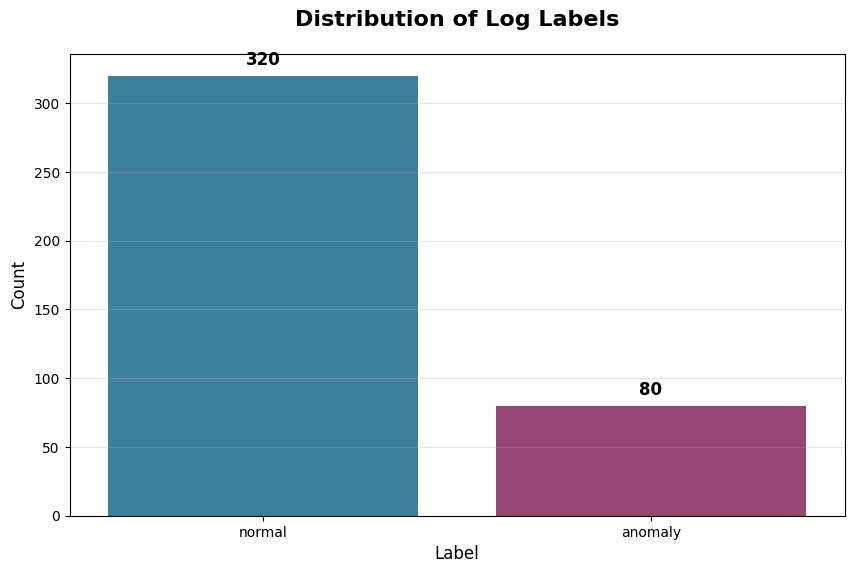

In [20]:
# Bar graph visualization of label distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Get value counts
label_counts = df["label"].value_counts()

# Create bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette=['#2E86AB', '#A23B72'])

# Add count labels on bars
for i, count in enumerate(label_counts.values):
    ax.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customize the plot
plt.title('Distribution of Log Labels', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', alpha=0.3)



In [24]:
# Create a copy for versioning
df2 = df.copy()

anomaly_log = "anomaly"
normal_log = "normal"

# Function to classify a single message
def classify_message(message):
    labels = [anomaly_log, "normal_log"]
    result = pipe(message, candidate_labels=labels)
    # Return the label with highest score and map to Excel format
    predicted = result['labels'][0]
    # Map back to Excel labels
    if predicted == anomaly_log:
        return "anomaly"
    else:  # normal_log
        return "normal"

# Apply classification to all messages
print("Starting inference on messages...")
df2['predicted_label'] = df2['message'].apply(classify_message)
print("Inference completed!")

Starting inference on messages...
Inference completed!


In [25]:
# Display sample predictions
df2[['message', 'label', 'predicted_label']]

,message,label,predicted_label
0,"AH00128: Served /api/users/123 200 OK, bytes=2...",normal,normal
1,"Handled /static/app.js 200 in 21ms, request_id...",normal,anomaly
2,mod_security: Access denied with code 403 (SQL...,anomaly,anomaly
3,"GET /api/login 200 OK in 49ms, user=user_6740,...",normal,normal
4,"200 OK served /api/login in 9ms, bytes_sent=89...",normal,normal
...,...,...,...
395,"AH00128: Served /api/orders 200 OK, bytes=1172...",normal,normal
396,"Authentication succeeded for user=user_3827, i...",normal,normal
397,"Connected to Mongo at search-5.prod.acme.io, p...",normal,normal
398,Connected to MongoDB at auth-6.dev.example.org...,normal,normal


In [26]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Create df3 for analysis
df3 = df2.copy()

# Calculate metrics
accuracy = accuracy_score(df3['label'], df3['predicted_label'])
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(df3['label'], df3['predicted_label']))

Accuracy: 0.7675

Classification Report:
              precision    recall  f1-score   support

     anomaly       0.46      1.00      0.63        80
      normal       1.00      0.71      0.83       320

    accuracy                           0.77       400
   macro avg       0.73      0.85      0.73       400
weighted avg       0.89      0.77      0.79       400



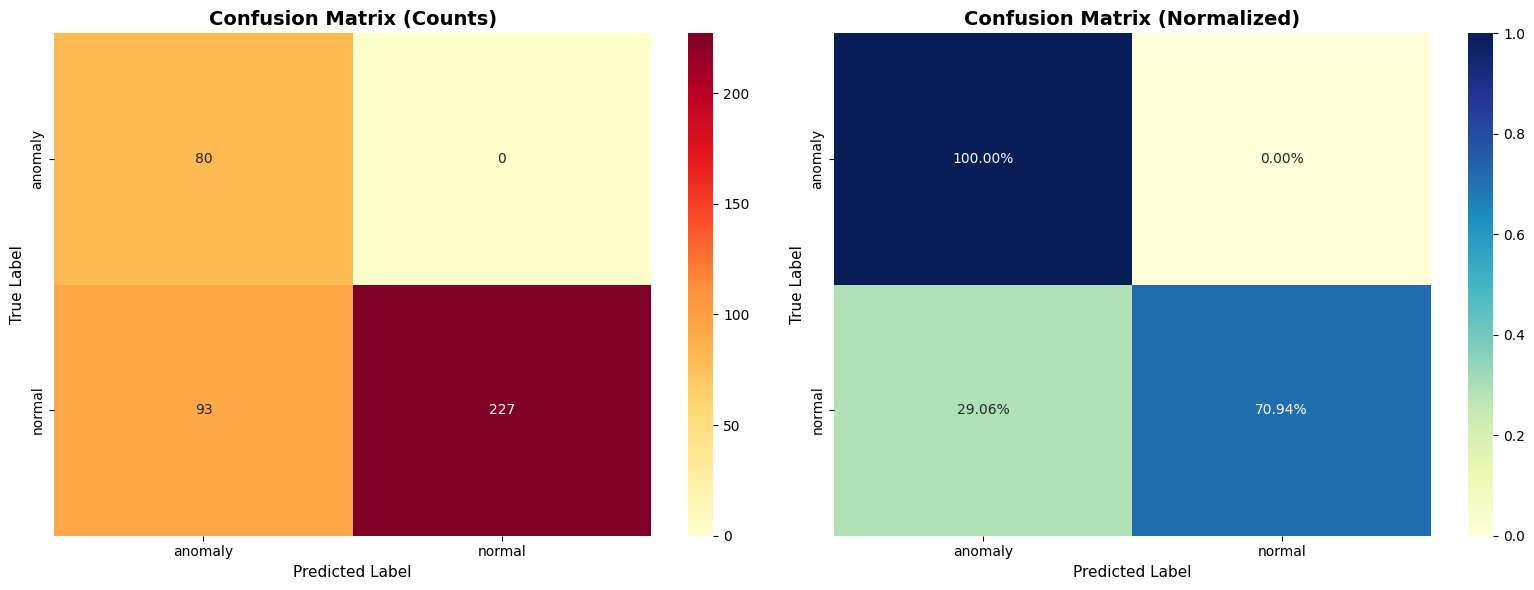

In [28]:
# Alternative: Confusion matrix with matplotlib (normalized)
cm_normalized = confusion_matrix(df3['label'], df3['predicted_label'], normalize='true')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=['anomaly', 'normal'], 
            yticklabels=['anomaly', 'normal'],
            ax=ax1)
ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=11)
ax1.set_xlabel('Predicted Label', fontsize=11)

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlGnBu', 
            xticklabels=['anomaly', 'normal'], 
            yticklabels=['anomaly', 'normal'],
            ax=ax2)
ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=11)
ax2.set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()